In [1]:
import pandas as pd
import pdb
import numpy as np
import itertools
from snakemake.io import expand
import yaml
import os
import sys
import pathlib
import pyranges as pr
import cerberus 
import swan_vis as swan
import met_brewer
import seaborn as sns

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from utils import *
from sm_utils import *
from humanized_utils import *

In [2]:
config_file = 'config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
swan_file = expand(config['swan']['swan_graph'], 
                   analysis='hABKI_Swe_IB_HET_WT')[0]
cerberus_h5 = 'data/cerberus/ad008/hABKI_Swe_IB_WT_M_8_weeks_HC_8_annot.h5'



In [4]:
sg = swan.read(swan_file)
obs = sg.adata.obs.copy(deep=True)

Read in graph from data/swan/hABKI_Swe_IB_HET_WT/swan_graph.p


In [5]:
# get unique genotypes, timepoints, tissues, etc
genotypes = obs.genotype.unique()
sex = obs.sex.unique()
ages = obs.age.unique()
tissues = obs.tissue.unique()

In [6]:
print(genotypes)
print(sex)
print(ages)
print(tissues)

['hABKI_Swe_IB_HET' 'hABKI_Swe_IB_WT']
['F' 'M']
['8_weeks']
['HC']


{0: '#2b9b81', 1: '#fe9b00', 2: '#f4c40f', 3: '#fbe183', 4: '#633372', 5: '#9b3441', 6: '#e6a2a6', 7: '#92c051', 8: '#1f6e9c', 9: '#9f5691', 10: '#e87b89'}


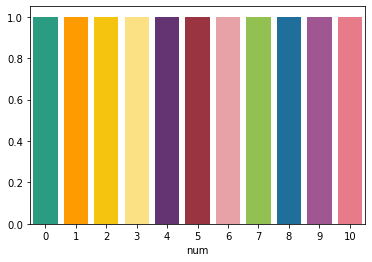

In [7]:
df = pd.DataFrame()
df['color'] = met_brewer.met_brew("Signac", n=11, brew_type="discrete")
df['num'] = df.index.tolist()
cmap = dict([(num, color) for num, color in zip(df.num.tolist(), df.color.tolist())])
print(cmap)
sns.barplot(df, y=[1 for i in range(len(df.index))], x='num', palette=cmap, saturation=1)

In [8]:
g_cmap = {'hABKI_Swe_IB_HET': cmap[1],
          'hABKI_Swe_IB_WT': cmap[2]}
s_cmap = {'M': cmap[3],
          'F': cmap[7]}
t_cmap = {'HC': cmap[10]}          

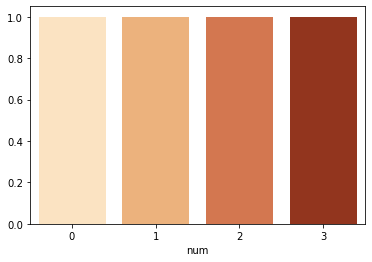

In [9]:
df = pd.DataFrame()
df['color'] = met_brewer.met_brew("OKeeffe2", n=4, brew_type="continuous")
df['num'] = df.index.tolist()
cmap = dict([(num, color) for num, color in zip(df.num.tolist(), df.color.tolist())])
sns.barplot(df, y=[1 for i in range(len(df.index))], x='num', palette=cmap, saturation=1)
order = ['8_weeks', 
         '10_weeks',
         '4_months',
         '18_months']
a_cmap = dict()
for i,t in enumerate(order):
    a_cmap[t] = cmap[i]

In [10]:
sg.set_metadata_colors('genotype', g_cmap)
sg.set_metadata_colors('tissue', t_cmap)
sg.set_metadata_colors('sex', s_cmap)
sg.set_metadata_colors('age', a_cmap)

## Filtering the DU results

In [27]:
import glob
# loc = 'data/swan/hABKI_Swe_IB_HET_WT/*genotype_sex_du_*.tsv'
loc = 'data/swan/hABKI_Swe_IB_HET_WT/*genotype_du*.tsv'
du_df = pd.DataFrame()
for f in glob.glob(loc):
    print(f)
    feat = f.rsplit('_')[-1].split('.')[0]
    cond1 = f.rsplit('/')[-1].split('_vs_')[0]
    cond2 = f.rsplit('/')[-1].split('_vs_')[1].split('_genotype')[0]
    # print(feat)
    # print(cond1)
    # print(cond2)
    temp = pd.read_csv(f, sep='\t')
    temp['feat'] = feat
    temp['cond1'] = cond1
    temp['cond2'] = cond2
    du_df = pd.concat([du_df, temp], axis=0)

data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_tss.tsv
data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_ic.tsv
data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_iso.tsv
data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_tes.tsv


In [28]:
t_df = swan.calc_tpm(sg.adata, obs_col='genotype')
t_df = t_df.sparse.to_dense()
t_df = t_df.T
t_df.reset_index(inplace=True)
t_df.rename({'index': 'tid'}, axis=1, inplace=True)

In [29]:
t_df['gid'] = t_df.tid.str.split('[', expand=True)[0]
t_df.drop('tid', axis=1, inplace=True)
g_df = t_df.groupby('gid').sum().reset_index()
g_df.head()
tpm_cols = g_df.columns[1:]
tpm_cols

Index(['hABKI_Swe_IB_HET', 'hABKI_Swe_IB_WT'], dtype='object')

In [30]:
du_df = du_df.merge(g_df, how='left', on='gid')

In [31]:
# filter df based on tpm
# at least one transcript must be expressed above >10 TPM 
print(len(du_df))
du_df = du_df.loc[du_df[tpm_cols].max(axis=1)>=10]
print(len(du_df))

35932
27046


In [34]:
# filter based on what the novelty type of transcripts is
# and how many exons (no monoexonic)
ca = cerberus.read(cerberus_h5)

In [35]:
print(len(du_df))
for c in ['pos_iso_1', 'pos_iso_2', 'neg_iso_1', 'neg_iso_2']:
    temp = ca.ic.copy(deep=True)
    temp['monoexonic'] = (temp.Coordinates == '-')
    temp = temp[['Name', 'novelty', 'monoexonic']]
    temp.rename({'Name': c,
                 'novelty': f'{c}_novelty',
                 'monoexonic': f'{c}_monoexonic'}, axis=1, inplace=True)
    du_df = du_df.merge(temp, how='left', on=c)
    
# no unspliced, no isms
bad_novs = ['ISM', 'Unspliced']
du_df = du_df.loc[~(du_df.pos_iso_1_novelty.isin(bad_novs))&\
                  ~(du_df.neg_iso_1_novelty.isin(bad_novs))]
print(len(du_df))

27046
24726


In [18]:
# no monoexonic
du_df = du_df.loc[(du_df.pos_iso_1_monoexonic==False)&\
                  (du_df.neg_iso_1_monoexonic==False)]
print(len(du_df))

14278


In [37]:
# filter on pval and dpi
adj_p_thresh = 0.05
dpi_thresh = 20
du_df = du_df.loc[(du_df.adj_p_val<=adj_p_thresh)&(du_df.dpi>=dpi_thresh)]
du_df.head()

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,...,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT,pos_iso_1_novelty,pos_iso_1_monoexonic,pos_iso_2_novelty,pos_iso_2_monoexonic,neg_iso_1_novelty,neg_iso_1_monoexonic,neg_iso_2_novelty,neg_iso_2_monoexonic
28,39,ENSMUSG00000000632,0.000000e+00,38.301750,ENSMUSG00000000632_7,ENSMUSG00000000632_6,28.080685,8.578466,ENSMUSG00000000632_1,NaN,...,284.659515,147.734161,Known,False,Known,False,Known,False,NaN,NaN
36,48,ENSMUSG00000000823,1.675203e-15,20.436955,ENSMUSG00000000823_1,ENSMUSG00000000823_2,15.605828,4.831127,ENSMUSG00000000823_3,NaN,...,22.910200,21.154467,Known,False,Known,False,Known,False,NaN,NaN
43,55,ENSMUSG00000000948,2.912477e-101,28.486624,ENSMUSG00000000948_6,ENSMUSG00000000948_5,26.735229,1.067920,ENSMUSG00000000948_1,ENSMUSG00000000948_7,...,81.340431,94.489845,NNC,False,NNC,False,Known,False,NNC,False
47,62,ENSMUSG00000001034,5.625502e-21,28.723003,ENSMUSG00000001034_4,NaN,28.722998,NaN,ENSMUSG00000001034_1,NaN,...,19.301006,15.537150,Known,False,NaN,NaN,Known,False,NaN,NaN
102,122,ENSMUSG00000001942,1.230453e-06,21.410543,ENSMUSG00000001942_1,ENSMUSG00000001942_4,15.084990,6.325554,ENSMUSG00000001942_5,NaN,...,9.359242,10.784737,Known,False,Known,True,Known,False,NaN,NaN


In [39]:
du_df[['gid', 'feat']].groupby('feat').count()

,gid
feat,
ic,269
iso,1151
tes,750
tss,275


In [40]:
du_df.loc[(du_df.feat=='ic')].sort_values(by='dpi', ascending=False).head(10).tail(10).gname

12261          Gm45640
5266             P4htm
11068            Rtl8c
12032          Plekhn1
11708            Ppcdc
9427             Ap2b1
8594              Ipo5
12174    A930015D03Rik
6176              Atl1
12237           Snhg14
Name: gname, dtype: object

In [23]:
# du_df = du_df.sort_values(by='dpi', ascending=False)
# du_df.loc[(du_df.feat=='ic')&\
#           (du_df.pos_iso_1_dpi.abs()!=100)&\
#           (du_df.pos_iso_2_dpi.abs()!=100)&\
#           (du_df.neg_iso_1_dpi.abs()!=100)&\
#           (du_df.neg_iso_2_dpi.abs()!=100)].head()

In [24]:
sg.ic_adata.var.head()

,gid,gname,ic_name
ic_id,,,
ENSMUSG00000000001_1,ENSMUSG00000000001,Gnai3,Gnai3_1
ENSMUSG00000000028_5,ENSMUSG00000000028,Cdc45,Cdc45_5
ENSMUSG00000000056_4,ENSMUSG00000000056,Narf,Narf_4
ENSMUSG00000000058_1,ENSMUSG00000000058,Cav2,Cav2_1
ENSMUSG00000000078_1,ENSMUSG00000000078,Klf6,Klf6_1


In [25]:
du_df.loc[(du_df.feat=='ic')].tail(20).head(10)

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,...,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT,pos_iso_1_novelty,pos_iso_1_monoexonic,pos_iso_2_novelty,pos_iso_2_monoexonic,neg_iso_1_novelty,neg_iso_1_monoexonic,neg_iso_2_novelty,neg_iso_2_monoexonic
11746,8738,ENSMUSG00000066151,5.917625e-09,23.724449,ENSMUSG00000066151_1,ENSMUSG00000066151_13,20.714630,3.009819,ENSMUSG00000066151_2,ENSMUSG00000066151_12,...,6.589409,10.833746,Known,False,NIC,False,Known,False,NIC,False
11756,8751,ENSMUSG00000066571,5.126801e-14,21.138211,ENSMUSG00000066571_10,ENSMUSG00000066571_12,15.176151,5.962059,ENSMUSG00000066571_11,ENSMUSG00000066571_1,...,12.791306,9.448186,Known,False,ISM,False,NIC,False,Known,False
11874,8912,ENSMUSG00000070953,2.989631e-40,45.110546,ENSMUSG00000070953_3,ENSMUSG00000070953_11,38.275119,6.835427,ENSMUSG00000070953_1,ENSMUSG00000070953_8,...,22.035051,9.789830,Known,False,NIC,False,Known,False,ISM,False
11882,8926,ENSMUSG00000071180,5.162333e-92,43.151908,ENSMUSG00000071180_5,ENSMUSG00000071180_4,28.905159,8.460173,ENSMUSG00000071180_2,NaN,...,28.056732,45.504471,Known,False,Known,False,Known,False,NaN,NaN
11931,8994,ENSMUSG00000072964,4.745561e-84,28.131175,ENSMUSG00000072964_24,ENSMUSG00000072964_2,14.251208,8.381765,ENSMUSG00000072964_19,ENSMUSG00000072964_27,...,28.244947,52.752193,NNC,False,Known,False,NNC,False,NNC,False
11997,9096,ENSMUSG00000074923,3.230034e-36,32.260498,ENSMUSG00000074923_8,NaN,32.260498,NaN,ENSMUSG00000074923_6,NaN,...,29.681038,22.640089,NNC,False,NaN,NaN,NNC,False,NaN,NaN
12032,9143,ENSMUSG00000078485,1.997284e-88,94.594594,ENSMUSG00000078485_13,ENSMUSG00000078485_11,54.054050,40.540539,ENSMUSG00000078485_12,ENSMUSG00000078485_14,...,1.363656,13.110827,NNC,False,NNC,False,NNC,False,NNC,False
12070,9194,ENSMUSG00000079036,1.098364e-12,20.412645,ENSMUSG00000079036_1,ENSMUSG00000079036_2,12.053986,8.358660,ENSMUSG00000079036_12,ENSMUSG00000079036_8,...,15.518479,13.306887,Known,False,Known,True,NNC,False,Known,False
12127,9303,ENSMUSG00000087143,2.390758e-15,27.907953,ENSMUSG00000087143_4,ENSMUSG00000087143_8,19.279217,8.628736,ENSMUSG00000087143_11,ENSMUSG00000087143_10,...,8.967472,11.147193,Known,False,NIC,False,NNC,False,NNC,False
12170,9369,ENSMUSG00000091780,4.630107e-67,36.869207,ENSMUSG00000091780_3,NaN,36.869205,NaN,ENSMUSG00000091780_2,ENSMUSG00000091780_1,...,33.966824,21.240953,NNC,False,NaN,NaN,Known,False,Known,False


In [41]:
def plot_report(sg, gene):
    study = sg.adata.obs.study.tolist()[0]
    sg.gen_report(gene,
                  f'figures/{gene}_{study}',
                  novelty=True,
                  cmap='viridis',
                  indicate_novel=True,
                  transcript_col='tname',
                  metadata_cols=['genotype', 'sex', 'tissue', 'age'],
                  datasets={'genotype': ['hABKI_Swe_IB_HET', 'hABKI_Swe_IB_WT']})
    sg.gen_report(gene,
                  f'figures/{gene}_{study}',
                  novelty=True,
                  cmap='viridis',
                  transcript_col='tname',
                  display_numbers=True,
                  browser=True,
                  layer='pi',
                  metadata_cols=['genotype', 'sex', 'tissue', 'age'],
                  datasets={'genotype': ['hABKI_Swe_IB_HET', 'hABKI_Swe_IB_WT']})

In [54]:
g = 'Atl1'
plot_report(sg, g)
du_df.loc[du_df.gname==g]


Plotting transcripts for ENSMUSG00000021066
Saving transcript path graph for ENSMUSG00000021066[3,8,5] as figures/Atl1_ad008_novel_ENSMUSG00000021066[3,8,5]_path.png
Saving transcript path graph for ENSMUSG00000021066[7,6,5] as figures/Atl1_ad008_novel_ENSMUSG00000021066[7,6,5]_path.png
Saving transcript path graph for ENSMUSG00000021066[3,9,5] as figures/Atl1_ad008_novel_ENSMUSG00000021066[3,9,5]_path.png
Saving transcript path graph for ENSMUSG00000021066[1,6,5] as figures/Atl1_ad008_novel_ENSMUSG00000021066[1,6,5]_path.png
Saving transcript path graph for ENSMUSG00000021066[2,6,5] as figures/Atl1_ad008_novel_ENSMUSG00000021066[2,6,5]_path.png
Saving transcript path graph for ENSMUSG00000021066[3,12,5] as figures/Atl1_ad008_novel_ENSMUSG00000021066[3,12,5]_path.png
Saving transcript path graph for ENSMUSG00000021066[3,13,5] as figures/Atl1_ad008_novel_ENSMUSG00000021066[3,13,5]_path.png
Saving transcript path graph for ENSMUSG00000021066[3,14,5] as figures/Atl1_ad008_novel_ENSMUSG00

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,...,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT,pos_iso_1_novelty,pos_iso_1_monoexonic,pos_iso_2_novelty,pos_iso_2_monoexonic,neg_iso_1_novelty,neg_iso_1_monoexonic,neg_iso_2_novelty,neg_iso_2_monoexonic
865,1034,ENSMUSG00000021066,1.642587e-115,52.213080,ENSMUSG00000021066_7,ENSMUSG00000021066_2,27.715052,14.293520,ENSMUSG00000021066_3,ENSMUSG00000021066_6,...,12.548113,69.657501,NIC,False,Known,False,Known,False,NNC,False
6176,1716,ENSMUSG00000021066,1.853199e-206,80.888679,ENSMUSG00000021066_6,ENSMUSG00000021066_9,52.117520,23.740571,ENSMUSG00000021066_8,ENSMUSG00000021066_13,...,12.548113,69.657501,NNC,False,NIC,False,NNC,False,NNC,False
13816,1922,ENSMUSG00000021066,1.500341e-211,80.888679,"ENSMUSG00000021066[7,6,5]","ENSMUSG00000021066[3,9,5]",27.715052,23.740571,"ENSMUSG00000021066[3,8,5]","ENSMUSG00000021066[3,13,5]",...,12.548113,69.657501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# g = 'Ipo5'
# plot_report(sg, g)
# du_df.loc[du_df.gname==g]

In [51]:
# g = 'Snhg14'
# plot_report(sg, g)
# du_df.loc[du_df.gname==g]

In [47]:
# du_df.loc[du_df.gname=='Rpl11']

In [48]:
# du_df.loc[du_df.gname=='Ap2b1']

In [49]:
# du_df.loc[du_df.gname=='Ap2b1', tpm_cols]

In [43]:
# g = 'Gm45640'
# plot_report(sg, g)
# du_df.loc[du_df.gname==g]

In [45]:
# g = 'Ap2b1'
# plot_report(sg, g)

In [46]:
# g ='Rpl11'
# plot_report(sg, g)

In [99]:
g ='Rtl8c'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000051851
Saving transcript path graph for ENSMUSG00000051851[1,2,3] as figures/Rtl8c_ad008_novel_ENSMUSG00000051851[1,2,3]_path.png
Saving transcript path graph for ENSMUSG00000051851[1,1,1] as figures/Rtl8c_ad008_novel_ENSMUSG00000051851[1,1,1]_path.png
Generating report for ENSMUSG00000051851

Plotting transcripts for ENSMUSG00000051851
Saving transcript path graph for ENSMUSG00000051851[1,2,3] as figures/Rtl8c_ad008_browser_ENSMUSG00000051851[1,2,3]_path.png
Saving transcript path graph for ENSMUSG00000051851[1,1,1] as figures/Rtl8c_ad008_browser_ENSMUSG00000051851[1,1,1]_path.png
Generating report for ENSMUSG00000051851


In [61]:
g = 'Sez6'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000000632
Saving transcript path graph for ENSMUSG00000000632[7,15,1] as figures/Sez6_ad008_novel_ENSMUSG00000000632[7,15,1]_path.png
Saving transcript path graph for ENSMUSG00000000632[7,16,1] as figures/Sez6_ad008_novel_ENSMUSG00000000632[7,16,1]_path.png
Saving transcript path graph for ENSMUSG00000000632[1,1,1] as figures/Sez6_ad008_novel_ENSMUSG00000000632[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000000632[6,13,1] as figures/Sez6_ad008_novel_ENSMUSG00000000632[6,13,1]_path.png
Saving transcript path graph for ENSMUSG00000000632[1,12,1] as figures/Sez6_ad008_novel_ENSMUSG00000000632[1,12,1]_path.png
Saving transcript path graph for ENSMUSG00000000632[6,14,1] as figures/Sez6_ad008_novel_ENSMUSG00000000632[6,14,1]_path.png
Saving transcript path graph for ENSMUSG00000000632[1,11,6] as figures/Sez6_ad008_novel_ENSMUSG00000000632[1,11,6]_path.png
Saving transcript path graph for ENSMUSG00000000632[7,10,1] as figures/Sez6_ad008_novel_E

In [49]:
g = 'Plekhn1'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000078485
Saving transcript path graph for ENSMUSG00000078485[1,12,4] as figures/Plekhn1_ad008_novel_ENSMUSG00000078485[1,12,4]_path.png
Saving transcript path graph for ENSMUSG00000078485[1,14,1] as figures/Plekhn1_ad008_novel_ENSMUSG00000078485[1,14,1]_path.png
Saving transcript path graph for ENSMUSG00000078485[1,13,1] as figures/Plekhn1_ad008_novel_ENSMUSG00000078485[1,13,1]_path.png
Saving transcript path graph for ENSMUSG00000078485[1,11,1] as figures/Plekhn1_ad008_novel_ENSMUSG00000078485[1,11,1]_path.png
Generating report for ENSMUSG00000078485

Plotting transcripts for ENSMUSG00000078485
Saving transcript path graph for ENSMUSG00000078485[1,12,4] as figures/Plekhn1_ad008_browser_ENSMUSG00000078485[1,12,4]_path.png
Saving transcript path graph for ENSMUSG00000078485[1,14,1] as figures/Plekhn1_ad008_browser_ENSMUSG00000078485[1,14,1]_path.png
Saving transcript path graph for ENSMUSG00000078485[1,13,1] as figures/Plekhn1_ad008_browser_ENSMUSG000

In [44]:
g = 'Filip1l'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000043336
Saving transcript path graph for ENSMUSG00000043336[4,4,4] as figures/Filip1l_ad008_novel_ENSMUSG00000043336[4,4,4]_path.png
Saving transcript path graph for ENSMUSG00000043336[3,3,3] as figures/Filip1l_ad008_novel_ENSMUSG00000043336[3,3,3]_path.png
Generating report for ENSMUSG00000043336

Plotting transcripts for ENSMUSG00000043336
Saving transcript path graph for ENSMUSG00000043336[4,4,4] as figures/Filip1l_ad008_browser_ENSMUSG00000043336[4,4,4]_path.png
Saving transcript path graph for ENSMUSG00000043336[3,3,3] as figures/Filip1l_ad008_browser_ENSMUSG00000043336[3,3,3]_path.png
Generating report for ENSMUSG00000043336


In [46]:
# g = 'Shank1'
# plot_report(sg, g)

In [43]:
g = 'Scyl2'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000069539
Saving transcript path graph for ENSMUSG00000069539[1,7,10] as figures/Scyl2_ad008_novel_ENSMUSG00000069539[1,7,10]_path.png
Saving transcript path graph for ENSMUSG00000069539[1,8,9] as figures/Scyl2_ad008_novel_ENSMUSG00000069539[1,8,9]_path.png
Saving transcript path graph for ENSMUSG00000069539[1,9,11] as figures/Scyl2_ad008_novel_ENSMUSG00000069539[1,9,11]_path.png
Saving transcript path graph for ENSMUSG00000069539[1,7,6] as figures/Scyl2_ad008_novel_ENSMUSG00000069539[1,7,6]_path.png
Generating report for ENSMUSG00000069539

Plotting transcripts for ENSMUSG00000069539
Saving transcript path graph for ENSMUSG00000069539[1,7,10] as figures/Scyl2_ad008_browser_ENSMUSG00000069539[1,7,10]_path.png
Saving transcript path graph for ENSMUSG00000069539[1,8,9] as figures/Scyl2_ad008_browser_ENSMUSG00000069539[1,8,9]_path.png
Saving transcript path graph for ENSMUSG00000069539[1,9,11] as figures/Scyl2_ad008_browser_ENSMUSG00000069539[1,9,11]_pat

In [17]:
g = 'Aida'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000042901
Saving transcript path graph for ENSMUSG00000042901[2,1,2] as figures/Aida_ad008_novel_ENSMUSG00000042901[2,1,2]_path.png
Saving transcript path graph for ENSMUSG00000042901[2,1,12] as figures/Aida_ad008_novel_ENSMUSG00000042901[2,1,12]_path.png
Saving transcript path graph for ENSMUSG00000042901[8,10,2] as figures/Aida_ad008_novel_ENSMUSG00000042901[8,10,2]_path.png
Saving transcript path graph for ENSMUSG00000042901[1,1,1] as figures/Aida_ad008_novel_ENSMUSG00000042901[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000042901[2,11,11] as figures/Aida_ad008_novel_ENSMUSG00000042901[2,11,11]_path.png
Saving transcript path graph for ENSMUSG00000042901[1,1,12] as figures/Aida_ad008_novel_ENSMUSG00000042901[1,1,12]_path.png
Saving transcript path graph for ENSMUSG00000042901[1,11,11] as figures/Aida_ad008_novel_ENSMUSG00000042901[1,11,11]_path.png
Saving transcript path graph for ENSMUSG00000042901[2,1,1] as figures/Aida_ad008_novel_

In [16]:
plot_report(sg, 'Satb2')


Plotting transcripts for ENSMUSG00000038331
Saving transcript path graph for ENSMUSG00000038331[1,1,1] as figures/Satb2_ad008_novel_ENSMUSG00000038331[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000038331[2,8,4] as figures/Satb2_ad008_novel_ENSMUSG00000038331[2,8,4]_path.png
Saving transcript path graph for ENSMUSG00000038331[2,6,1] as figures/Satb2_ad008_novel_ENSMUSG00000038331[2,6,1]_path.png
Generating report for ENSMUSG00000038331

Plotting transcripts for ENSMUSG00000038331
Saving transcript path graph for ENSMUSG00000038331[1,1,1] as figures/Satb2_ad008_browser_ENSMUSG00000038331[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000038331[2,8,4] as figures/Satb2_ad008_browser_ENSMUSG00000038331[2,8,4]_path.png
Saving transcript path graph for ENSMUSG00000038331[2,6,1] as figures/Satb2_ad008_browser_ENSMUSG00000038331[2,6,1]_path.png
Generating report for ENSMUSG00000038331


In [57]:
plot_report(sg, 'Tle3')


Plotting transcripts for ENSMUSG00000032280
Saving transcript path graph for ENSMUSG00000032280[12,21,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[12,21,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[12,21,1] as figures/Tle3_ad008_novel_ENSMUSG00000032280[12,21,1]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,4,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,4,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[4,4,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[4,4,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,4,1] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000032280[1,6,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[1,6,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,6,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,6,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,6,1] as figures/Tle3_ad008_novel_ENSMUS

In [56]:
plot_report(sg, 'Serpinb1b')


Plotting transcripts for ENSMUSG00000051029
Saving transcript path graph for ENSMUSG00000051029[2,3,4] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,3,4]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,4,1] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,3,1] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,3,1]_path.png
Generating report for ENSMUSG00000051029

Plotting transcripts for ENSMUSG00000051029
Saving transcript path graph for ENSMUSG00000051029[2,3,4] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,3,4]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,4,1] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,3,1] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,3,1]_path.png
Generating report for ENSMUSG00000051029


In [58]:
g = 'Dclre1c'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000026648
Saving transcript path graph for ENSMUSG00000026648[1,2,3] as figures/Dclre1c_ad008_novel_ENSMUSG00000026648[1,2,3]_path.png
Saving transcript path graph for ENSMUSG00000026648[1,1,1] as figures/Dclre1c_ad008_novel_ENSMUSG00000026648[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000026648[1,10,3] as figures/Dclre1c_ad008_novel_ENSMUSG00000026648[1,10,3]_path.png
Generating report for ENSMUSG00000026648

Plotting transcripts for ENSMUSG00000026648
Saving transcript path graph for ENSMUSG00000026648[1,2,3] as figures/Dclre1c_ad008_browser_ENSMUSG00000026648[1,2,3]_path.png
Saving transcript path graph for ENSMUSG00000026648[1,1,1] as figures/Dclre1c_ad008_browser_ENSMUSG00000026648[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000026648[1,10,3] as figures/Dclre1c_ad008_browser_ENSMUSG00000026648[1,10,3]_path.png
Generating report for ENSMUSG00000026648


In [53]:
g = 'Kank1'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000032702
Saving transcript path graph for ENSMUSG00000032702[1,14,6] as figures/Kank1_ad008_novel_ENSMUSG00000032702[1,14,6]_path.png
Saving transcript path graph for ENSMUSG00000032702[3,11,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[3,11,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[6,7,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[6,7,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[1,6,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[1,6,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[6,8,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[6,8,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[3,8,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[3,8,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[3,7,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[3,7,1]_path.png
Generating report for ENSMUSG00000032702

Plotting transcripts for ENSMUSG00000032702
Savi

In [54]:
g = 'Hdac7'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000022475
Saving transcript path graph for ENSMUSG00000022475[3,16,5] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[3,16,5]_path.png
Saving transcript path graph for ENSMUSG00000022475[9,15,1] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[9,15,1]_path.png
Saving transcript path graph for ENSMUSG00000022475[3,14,1] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[3,14,1]_path.png
Saving transcript path graph for ENSMUSG00000022475[3,1,1] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[3,1,1]_path.png
Saving transcript path graph for ENSMUSG00000022475[1,1,1] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[1,1,1]_path.png
Generating report for ENSMUSG00000022475

Plotting transcripts for ENSMUSG00000022475
Saving transcript path graph for ENSMUSG00000022475[3,16,5] as figures/Hdac7_ad008_browser_ENSMUSG00000022475[3,16,5]_path.png
Saving transcript path graph for ENSMUSG00000022475[9,15,1] as figures/Hdac7_ad008_browser_ENSMUSG00000022475[9,15,1]_pat

In [55]:
g = 'Shank1'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000038738
Saving transcript path graph for ENSMUSG00000038738[13,7,11] as figures/Shank1_ad008_novel_ENSMUSG00000038738[13,7,11]_path.png
Saving transcript path graph for ENSMUSG00000038738[11,15,8] as figures/Shank1_ad008_novel_ENSMUSG00000038738[11,15,8]_path.png
Saving transcript path graph for ENSMUSG00000038738[13,7,12] as figures/Shank1_ad008_novel_ENSMUSG00000038738[13,7,12]_path.png
Saving transcript path graph for ENSMUSG00000038738[13,7,13] as figures/Shank1_ad008_novel_ENSMUSG00000038738[13,7,13]_path.png
Saving transcript path graph for ENSMUSG00000038738[11,14,8] as figures/Shank1_ad008_novel_ENSMUSG00000038738[11,14,8]_path.png
Saving transcript path graph for ENSMUSG00000038738[11,15,10] as figures/Shank1_ad008_novel_ENSMUSG00000038738[11,15,10]_path.png
Saving transcript path graph for ENSMUSG00000038738[13,7,15] as figures/Shank1_ad008_novel_ENSMUSG00000038738[13,7,15]_path.png
Saving transcript path graph for ENSMUSG00000038738[5,6,5

In [59]:
g = 'Abcg1'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000024030
Saving transcript path graph for ENSMUSG00000024030[4,6,9] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[4,6,9]_path.png
Saving transcript path graph for ENSMUSG00000024030[4,6,6] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[4,6,6]_path.png
Saving transcript path graph for ENSMUSG00000024030[4,6,1] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[4,6,1]_path.png
Saving transcript path graph for ENSMUSG00000024030[1,1,6] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[1,1,6]_path.png
Saving transcript path graph for ENSMUSG00000024030[1,1,1] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000024030[1,7,7] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[1,7,7]_path.png
Saving transcript path graph for ENSMUSG00000024030[1,1,9] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[1,1,9]_path.png
Generating report for ENSMUSG00000024030

Plotting transcripts for ENSMUSG00000024030
Saving t

In [60]:
g = 'Filip1l'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000043336
Saving transcript path graph for ENSMUSG00000043336[4,4,4] as figures/Filip1l_ad008_novel_ENSMUSG00000043336[4,4,4]_path.png
Saving transcript path graph for ENSMUSG00000043336[3,3,3] as figures/Filip1l_ad008_novel_ENSMUSG00000043336[3,3,3]_path.png
Generating report for ENSMUSG00000043336

Plotting transcripts for ENSMUSG00000043336
Saving transcript path graph for ENSMUSG00000043336[4,4,4] as figures/Filip1l_ad008_browser_ENSMUSG00000043336[4,4,4]_path.png
Saving transcript path graph for ENSMUSG00000043336[3,3,3] as figures/Filip1l_ad008_browser_ENSMUSG00000043336[3,3,3]_path.png
Generating report for ENSMUSG00000043336


In [64]:
g = 'Picalm'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000039361
Saving transcript path graph for ENSMUSG00000039361[10,7,4] as figures/Picalm_ad008_novel_ENSMUSG00000039361[10,7,4]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,3,2] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,3,2]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,6,2] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,6,2]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,7,4] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,7,4]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,1,2] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,1,2]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,20,2] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,20,2]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,3,12] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,3,12]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,5,2] as figures/Picalm_ad00